### **数据分析** <br>
先从user侧(点击日志train、test)和item侧(各属性及id embe)**分别**进行分析：<br>
    （1）**user侧**如：用户环境变化、阅读文章的前后时间差、点击历史等等<br>
    （2）**item侧**如：文章创建时间、文章字数分布、文章主题类别数及每个类别的数量等等<br>
然后再分析**user-item的交互属性**，两大方向：<br>
    （1）以item反映用户的特征如：用户点击看过的文章中有多少主题类别、用户点击看过的文字的平均字数<br>
    （2）以user反映item的特征如：文章被点击次数等等<br>


In [17]:
# 导入相关包
%matplotlib inline
import gc
import os
import re
import sys
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rc('font', size=13)

warnings.filterwarnings("ignore")

#导入数据
root_path=Path(os.getcwd())
os.chdir(os.getcwd())
data_path = root_path/'data'

# 训练集
trn_click = pd.read_csv(data_path / 'train_click_log.csv')
item_df = pd.read_csv(data_path / 'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #将article_id重命名为click_article_id，方便后续match
item_emb_df = pd.read_csv(data_path / 'articles_emb.csv')

# 测试集
tst_click = pd.read_csv(data_path / 'testA_click_log.csv')

### **分析总结栏**<br>
所有特征有：
用户侧特征
user_id                 用户id
click_article_id	    点击文章id
click_timestamp	        点击时间戳
click_environment	    点击环境
click_deviceGroup	    点击设备组
click_os	            点击操作系统
click_country	        点击城市
click_region	        点击地区
click_referrer_type	    点击来源类型

项目侧特征
article_id	            文章id，与click_article_id相对应
category_id	            文章类型id
created_at_ts	        文章创建时间戳
words_count	            文章字数
article_emb	            文章embedding向量表示(item id)


两两配看怎么去分析。
user_to_item： item热度、
item_to_user：user活跃度、用户偏好item的xx属性。。。


#### **单侧分析——user侧**

In [18]:
# 对每个用户的点击时间戳进行排序(交互历史按时间顺序排列)
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

#统计每个用户的交互次数
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')


In [19]:
#数据总览
##训练集用户点击日志
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id']) #接入文章的特征
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [20]:
#用户点击日志信息
trn_click.info()

trn_click.describe() #能看到取值范围、均值、分位数等，对一些连续特征和离散特征有用

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 118.8 MB


,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [21]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [22]:
# 训练集里面每个用户至少点击了多少篇文章？————两篇
trn_click.groupby('user_id')['click_article_id'].count().min()  
#序列建模要设定固定序列长度，得根据trn_click['click_cnts']的分布情况来决定。

np.int64(2)

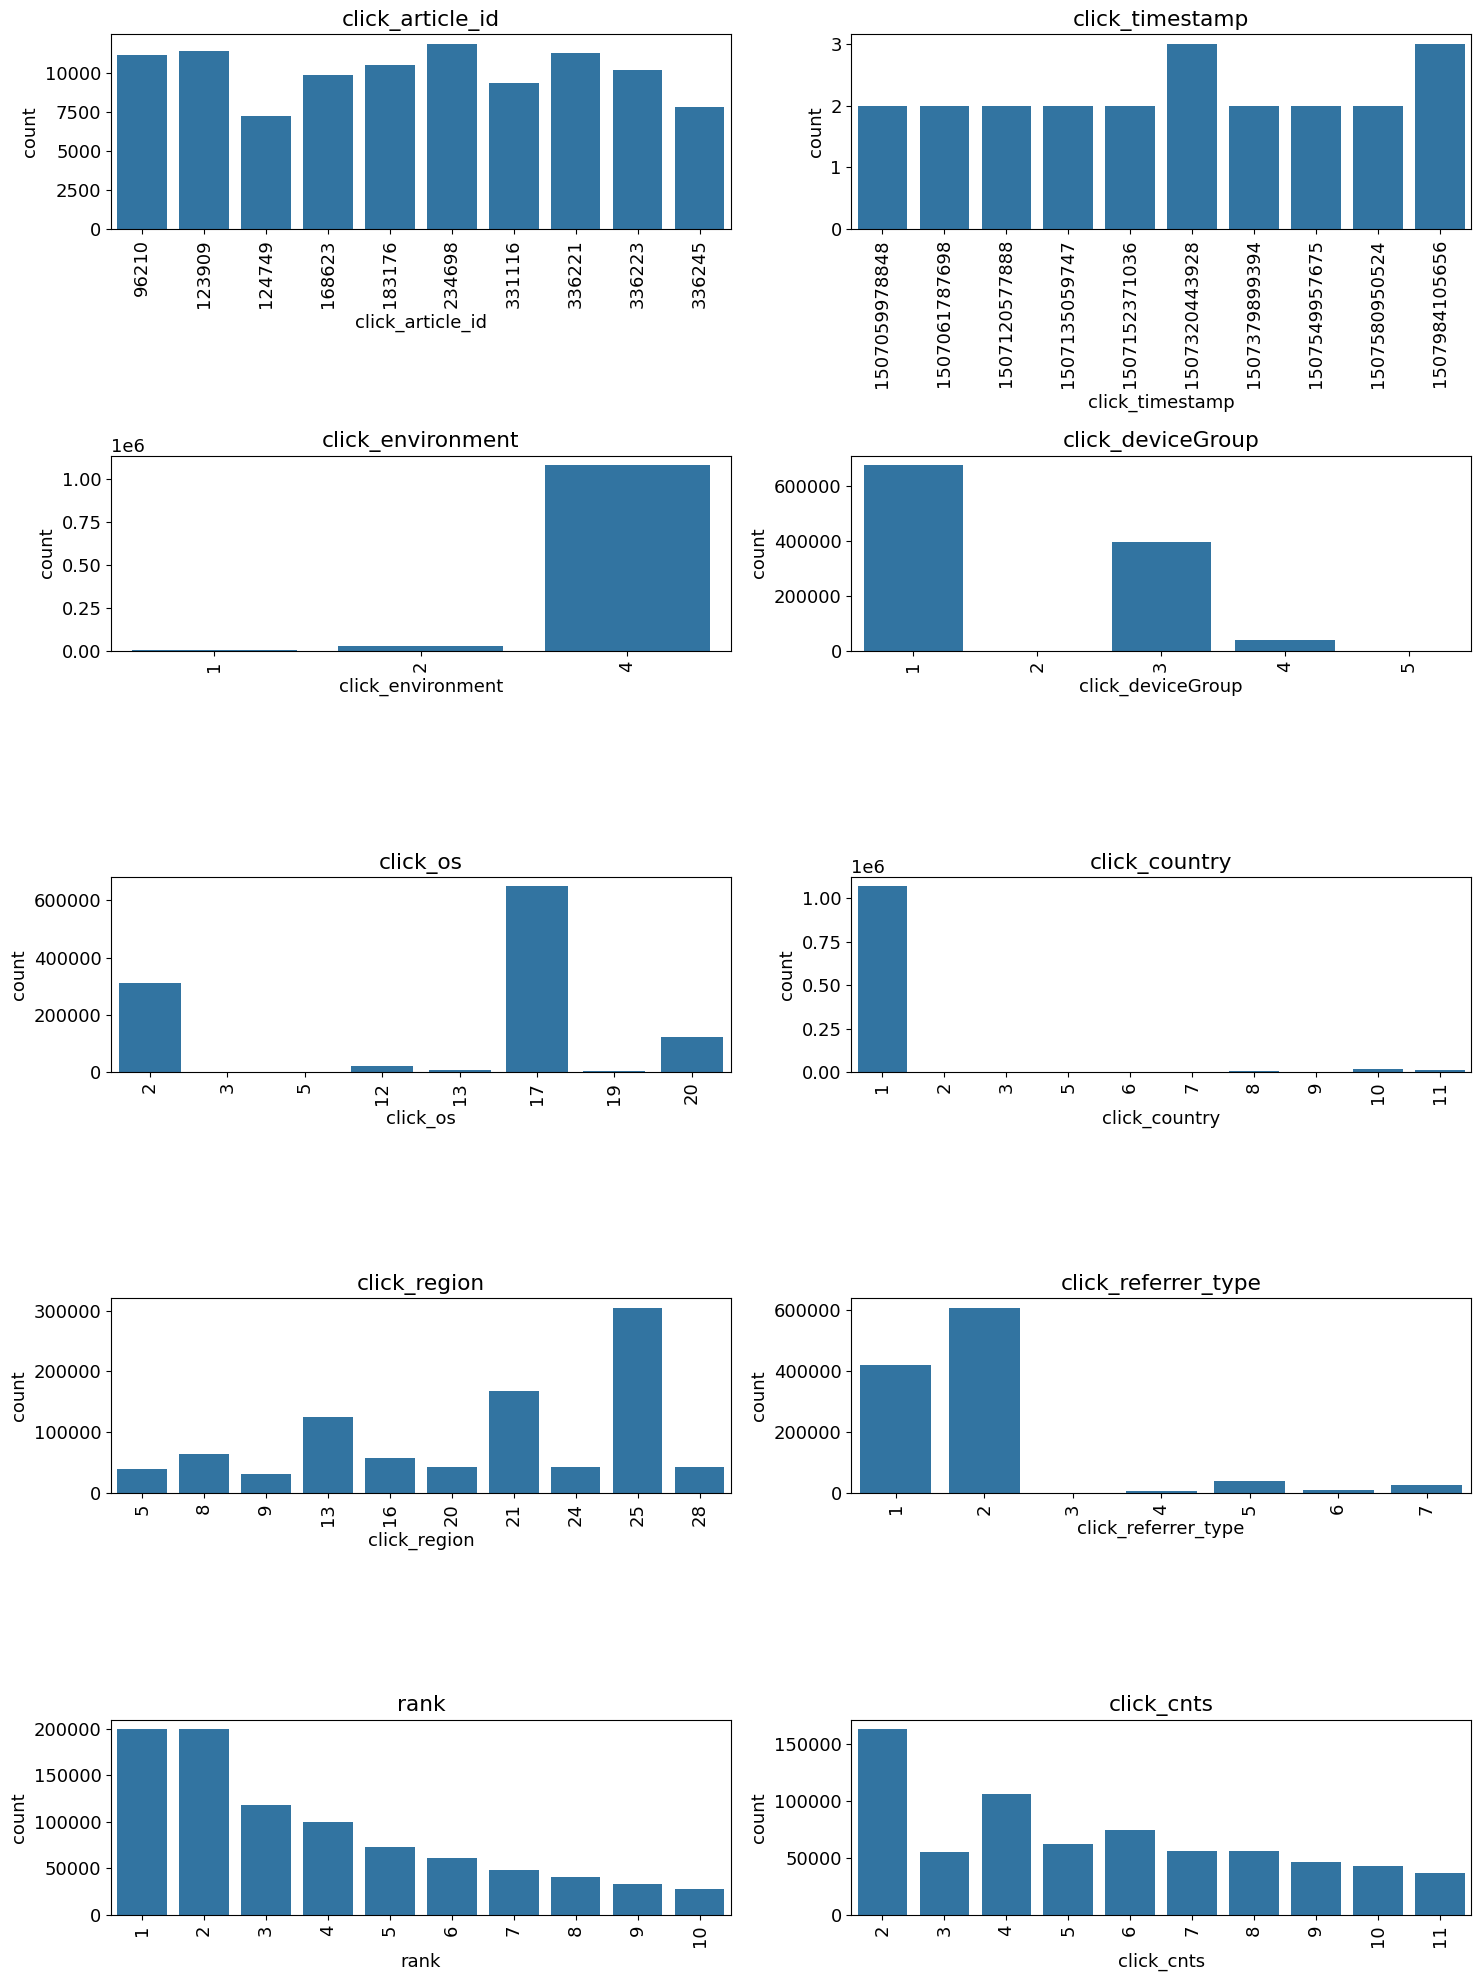

In [23]:
#训练集用户侧各个特征的分布情况
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country',
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10] #展示前十个 数据庞大全部展示太慢
    # Use iloc to access columns by position to avoid column name issues
    fig = sns.barplot(x=v.iloc[:, 0], y=v.iloc[:, 1])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()


一些特征是可以利用**前十个**高频率来初步分析：<br>
（1）从**点击时间clik_timestamp**来看，分布较为平均，可不做特殊处理。由于时间戳是13位的，后续将时间格式转换成10位方便计算。<br>
（2）从**点击环境click_environment**来看，仅有1922次（占0.1%）点击环境为1；仅有24617次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4，所以这个特征可能是无用的<br>
（3）从**点击设备组click_deviceGroup**来看，设备1占大部分（60.4%），设备3占36%<br>
（4）从**点击城市click_country**来看，基本上只在某一个城市，所以这个特征可能是无用的<br>
（5）从**点击系统click_os**来看,主要集中在三大类系统2、17、20中，其中17最多；可以考虑2/17/20/其余 分为4大类<br>

用户交互历史<br>
（1）从**点击rank**来看，第一次点击和第二次点击持平(即所有用户至少点了两次),后续第k次点击呈逐步递减,即越长越少用户点到<br>
（2）从**用户点击总数**来看,大多数用户只点了2次，后续点击总数比较平稳，可以从点击总数去看活跃度么？————后续继续分析更合理的活跃度度量<br>


另一些如文章点击次数(文章有很多),只看**前十个是不足以辨别出分布情况**的。<br>
（1）文章被点击频率~后续再分析是否长尾情况<br>


In [24]:
#测试集用户点击日志 ~主要看和训练集的差异
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [25]:
tst_click.describe()

#测试集中的用户数量为5w
tst_click.user_id.nunique()

# 注意测试集里面有只点击过一次文章的用户 ~和训练集差异不大
tst_click.groupby('user_id')['click_article_id'].count().min() 

np.int64(1)

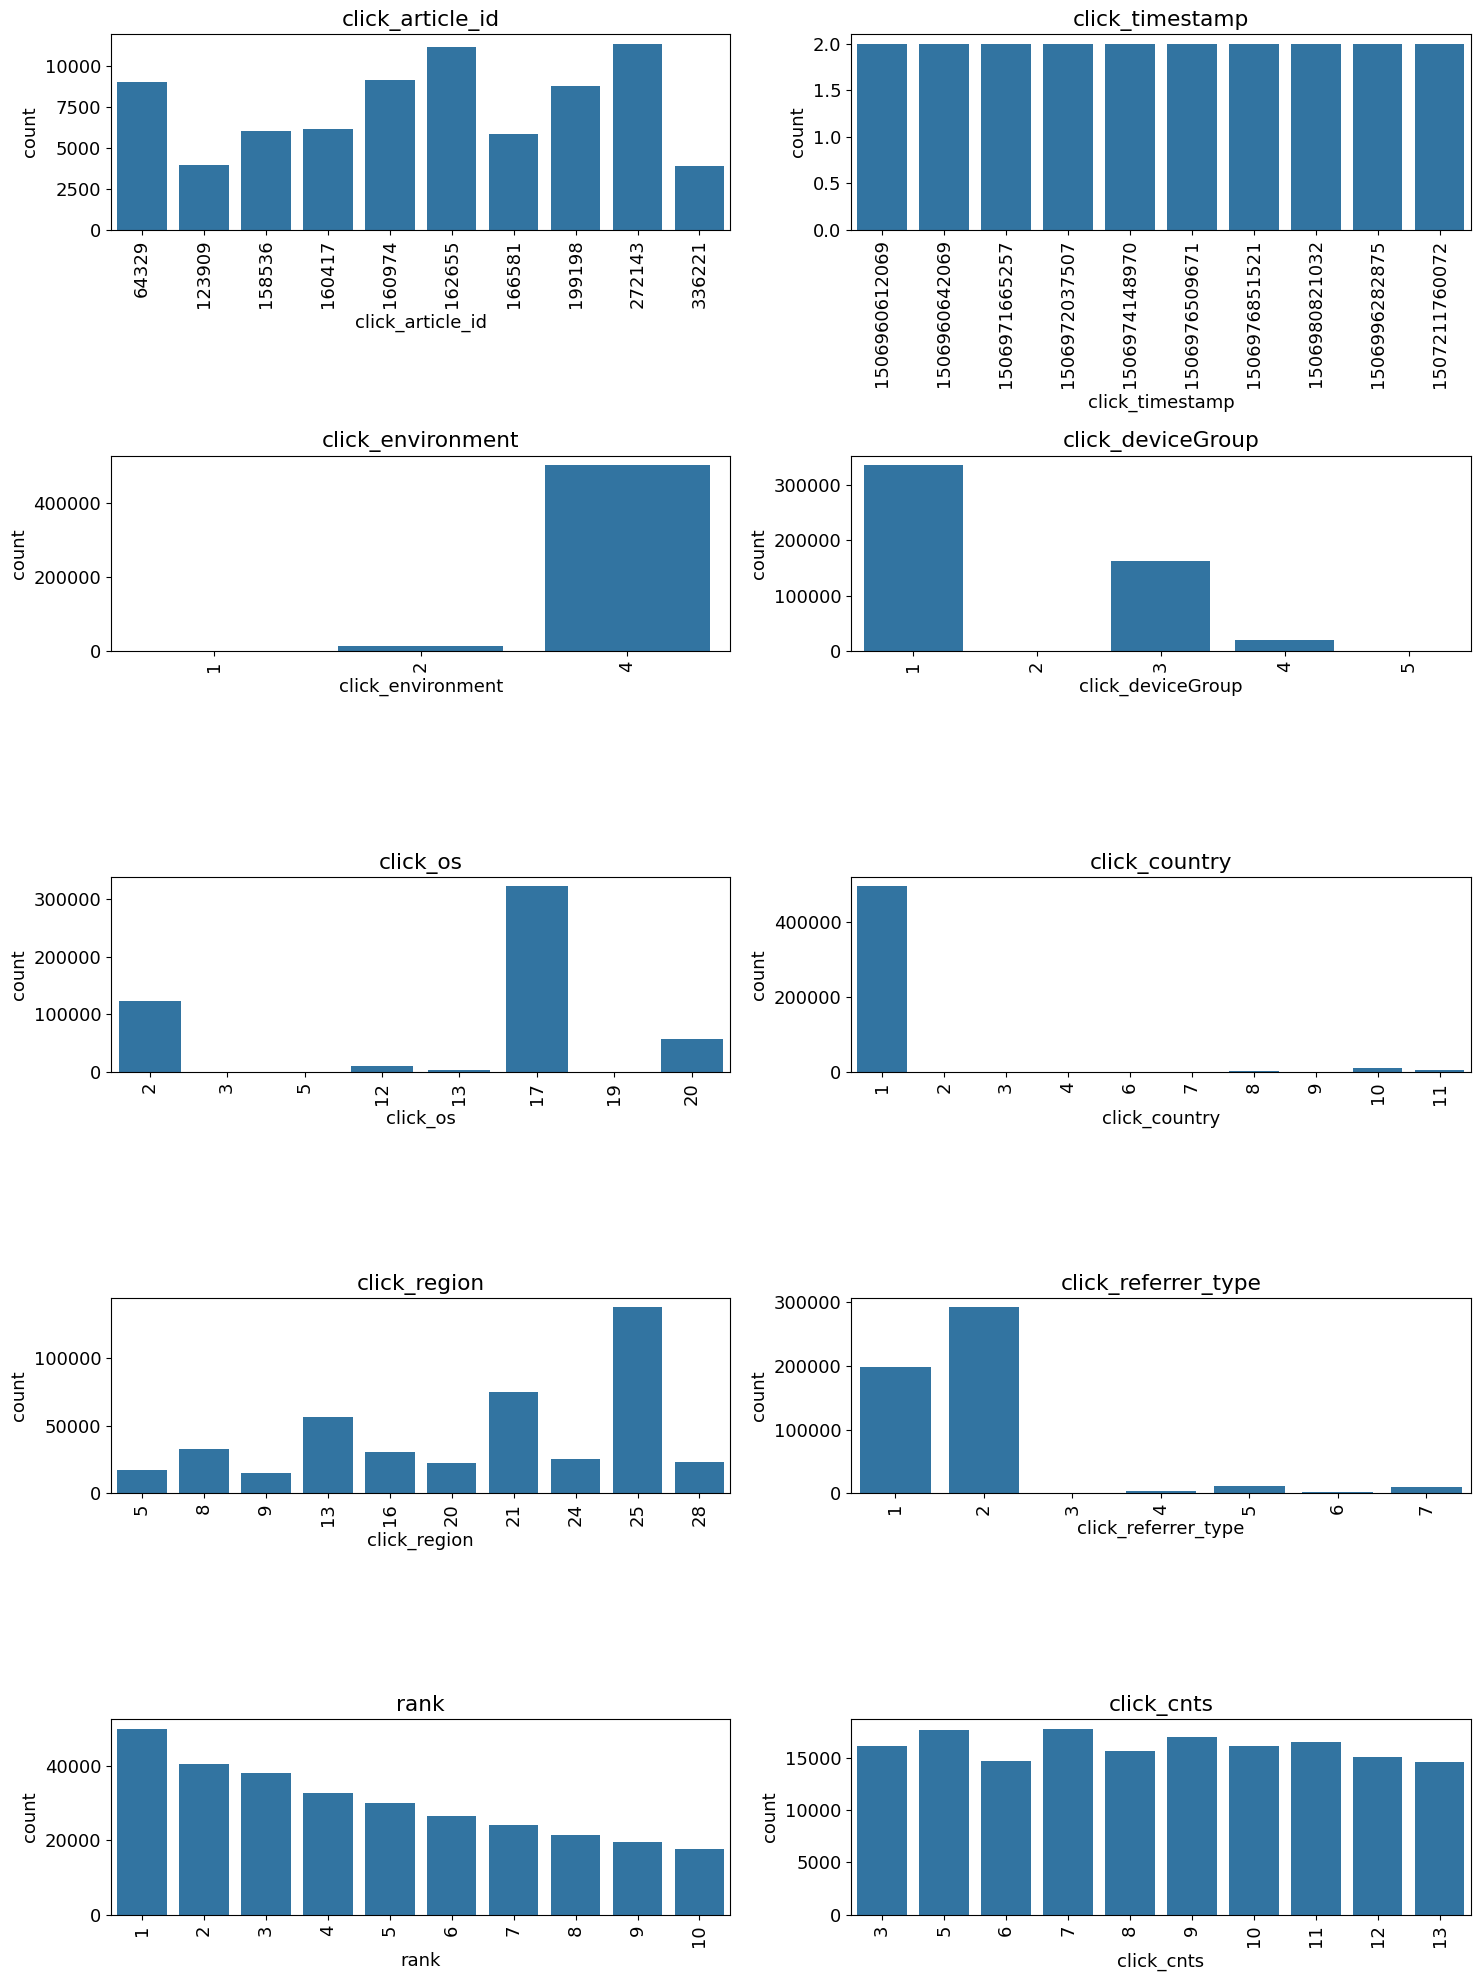

In [26]:
#测试集分布图
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country',
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = tst_click[col].value_counts().reset_index()[:10] #展示前十个 数据庞大全部展示太慢
    # Use iloc to access columns by position to avoid column name issues
    fig = sns.barplot(x=v.iloc[:, 0], y=v.iloc[:, 1])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

可以看到,**测试集的分布和训练集分布类似**

#### **单侧分析——item侧**

In [27]:
#新闻文章数据集浏览 ~除了id外,4个特征：类别、创建时间、词数。
print(item_df.head())
print("-"*100)
print(item_df.describe())#可以发现，item库总共36万左右。
print("-"*100)
print(item_df.info())


   click_article_id  category_id  created_at_ts  words_count
0                 0            0  1513144419000          168
1                 1            1  1405341936000          189
2                 2            1  1408667706000          250
3                 3            1  1408468313000          230
4                 4            1  1407071171000          162
----------------------------------------------------------------------------------------------------
       click_article_id    category_id  created_at_ts    words_count
count     364047.000000  364047.000000   3.640470e+05  364047.000000
mean      182023.000000     283.108239   1.474070e+12     190.897727
std       105091.461061     136.723470   4.293038e+10      59.502766
min            0.000000       0.000000   1.159356e+12       0.000000
25%        91011.500000     199.000000   1.444925e+12     159.000000
50%       182023.000000     301.000000   1.489422e+12     186.000000
75%       273034.500000     399.000000   1.509891e

In [28]:
#文章的词数分布
pd.set_option('display.max_rows', None)
item_df['words_count'].value_counts()
#_ = item_df['words_count'].hist(figsize=(5, 4), grid=False)


words_count
176     3485
182     3480
179     3463
178     3458
174     3456
183     3432
184     3427
173     3414
180     3403
177     3391
170     3387
187     3355
169     3352
185     3348
175     3346
181     3330
186     3328
189     3327
171     3327
172     3322
165     3308
188     3288
167     3269
190     3261
192     3257
168     3248
193     3225
166     3199
191     3182
194     3164
196     3128
162     3119
164     3114
195     3093
197     3069
161     3051
199     3047
163     3041
160     3020
202     3020
198     2990
159     2980
158     2936
201     2919
200     2905
156     2882
157     2881
203     2853
154     2850
205     2777
153     2744
155     2744
204     2706
206     2691
152     2672
207     2656
209     2636
208     2635
210     2591
151     2579
212     2557
211     2556
150     2547
149     2506
213     2465
147     2414
148     2373
214     2370
216     2343
146     2339
215     2312
218     2292
217     2289
145     2251
219     2241
144     2173


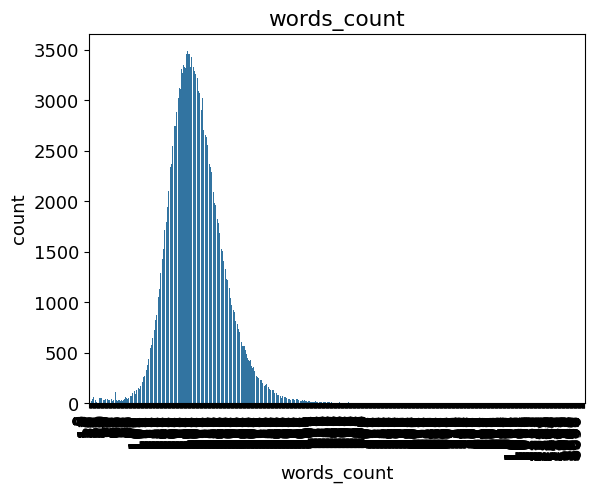

In [29]:
v = item_df['words_count'].value_counts().reset_index()#总共866种词数,横坐标重叠了不好看...
fig = sns.barplot(x=v.iloc[:, 0], y=v.iloc[:, 1])
#for item in fig.get_xticklabels():
#        item.set_rotation(90)
plt.xticks(rotation=90, ha='right')
plt.title("words_count")
plt.show()

In [30]:
print(item_df['words_count'].describe())
item_df['words_count'].quantile([0.9,0.99,0.999,0.9995,0.9999])

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64


0.9000     252.0000
0.9900     336.0000
0.9990     595.0000
0.9995     860.9310
0.9999    1542.7402
Name: words_count, dtype: float64

可以发现,词数分布(前99%)下服从正态分布，有特别长的词数。
所以**可以考虑将文章按词数特征分为类似长/中/短 的几类**<br>
分析0.9、0.99等分位数，0~25%：短；25~75%：中；75~99%：长； >999:超长<br>
即 短:<159 中：160~218 长：218~600 超长：>600

461


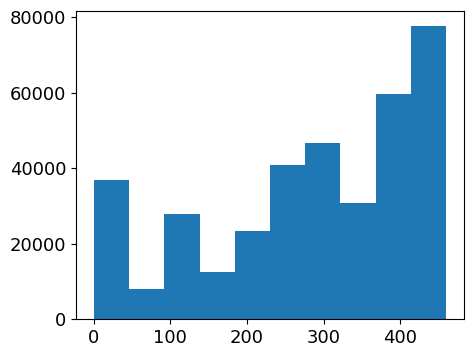

In [31]:
#文章的类别分布————但最终还是看用户看哪些类别多(user_to_item)
print(item_df['category_id'].nunique())     # 461个文章主题
_ = item_df['category_id'].hist(figsize=(5, 4), grid=False)

In [32]:
item_df['category_id'].describe()

count    364047.000000
mean        283.108239
std         136.723470
min           0.000000
25%         199.000000
50%         301.000000
75%         399.000000
max         460.000000
Name: category_id, dtype: float64

In [ ]:
#item的id embedding
print(item_emb_df.head())
print("-"*100)
print(item_emb_df.shape) #每个item都有id了————没缺失。因为总数都为364047

   article_id     emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
0           0 -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365   
1           1 -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297   
2           2 -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535   
3           3 -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745   
4           4 -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913   

      emb_6     emb_7     emb_8  ...   emb_240   emb_241   emb_242   emb_243  \
0 -0.335148 -0.559561 -0.500603  ...  0.321248  0.313999  0.636412  0.169179   
1 -0.715657 -0.897996 -0.359747  ... -0.487843  0.823124  0.412688 -0.338654   
2 -0.730477 -0.066126 -0.754899  ...  0.454756  0.473184  0.377866 -0.863887   
3 -0.825593 -0.710591 -0.040099  ...  0.271535  0.036040  0.480029 -0.763173   
4 -0.568816  0.341194 -0.600554  ...  0.238286  0.809268  0.427521 -0.615932   

    emb_244   emb_245   emb_246   emb_247   emb_248   em

#### **双侧分析——item_to_user**

In [33]:
#合并训练集和测试集一起看,因为从各个特征分布差异不大
user_click_merge = pd.concat([trn_click, tst_click])

In [34]:
#用户重复点击某一个文章的分析
#groupby(['user_id', 'click_article_id'])~每个用户对点击过的每一篇文章进行分组。
#['click_timestamp']~提出时间戳~相当于有多少次；agg({'count'})~聚合,统计总数。
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()

print("点击同一文章的重复次数的取值范围:",user_click_count['count'].unique())

print(user_click_count[user_click_count['count']>7])

#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts()

点击同一文章的重复次数的取值范围: [ 1  2  4  3  6  5 10  7 13]
        user_id  click_article_id  count
311242    86295             74254     10
311243    86295             76268     10
393761   103237            205948     10
393763   103237            235689     10
576902   134850             69463     13


count
1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

可以看出：**有1605541（约占99.2%）的用户未重复阅读过文章**，仅有极少数用户重复点击过某篇文章。 可以考虑这个单独制作成用户特征

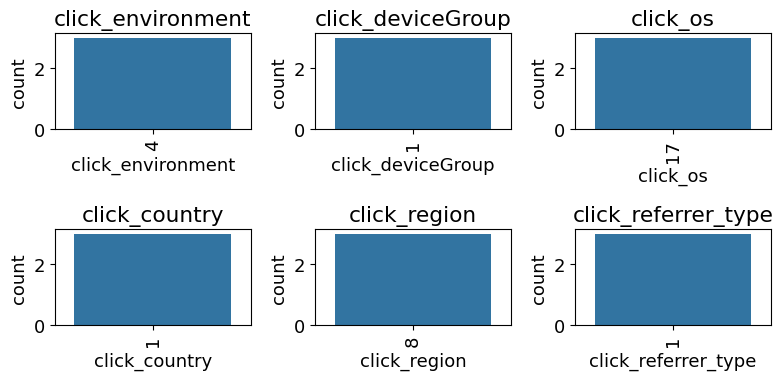

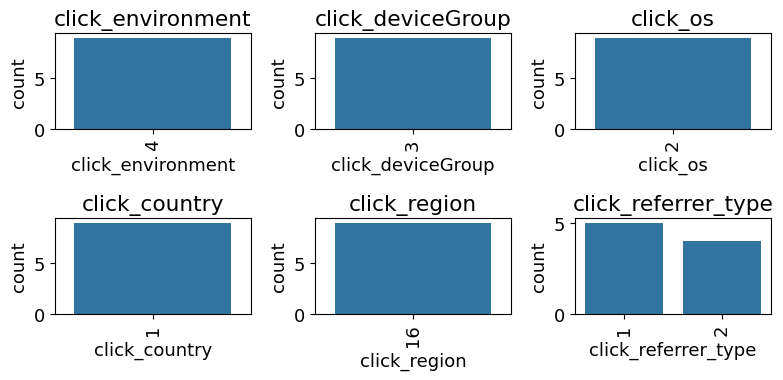

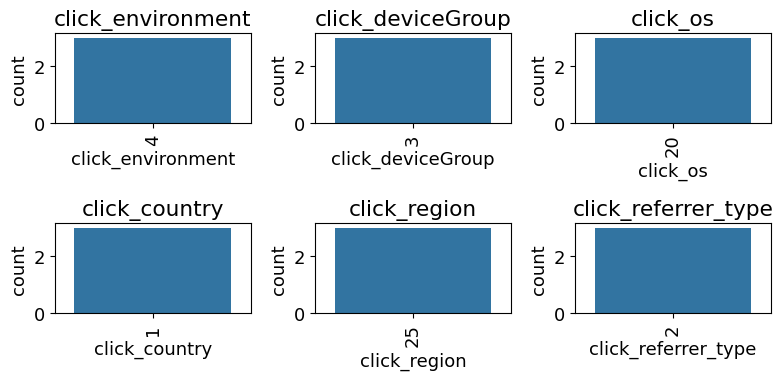

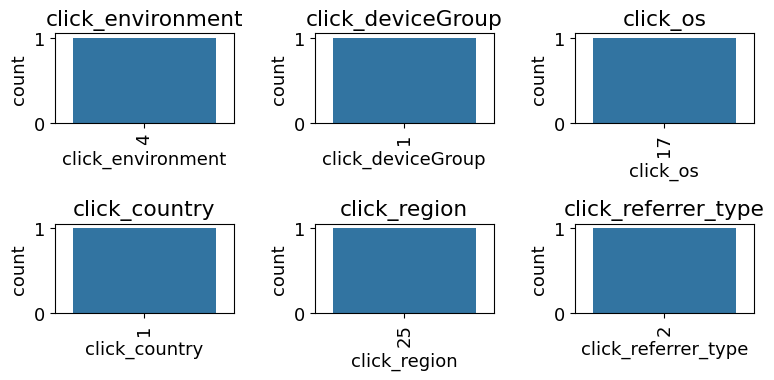

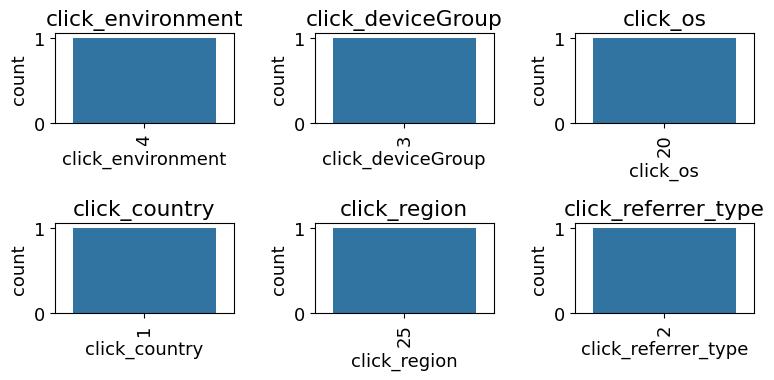

In [35]:
#很自然会想：用户整个点击序列，点击环境等类似特征会发生变化————如在家和在公司看的新闻类别很大差异等等————即上下文信息
def plot_envs(df, cols, r, c, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v.iloc[:, 0], y=v.iloc[:, 1])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=5, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3, figsize=(8, 4))

多随机几次，可以发现：<br>
（1）绝大多数数的用户的**点击环境是比较固定的**。思路：可以基于**这些环境的统计特征**来**代表该用户本身的属性**<br>
（2）最有可能变化的是点击的文章来源发生变化<br>

In [67]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


250000

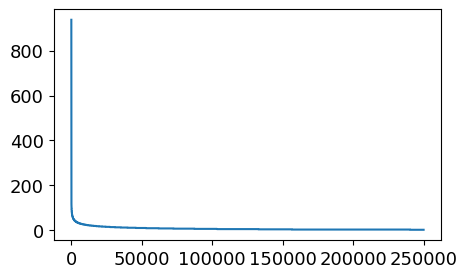

In [36]:
#用户点击新闻数量的分布————再次分析不同用户点击次数的分布
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count().values, reverse=True)
plt.figure(figsize=(5, 3))
_ = plt.plot(user_click_item_count)
len(user_click_item_count)

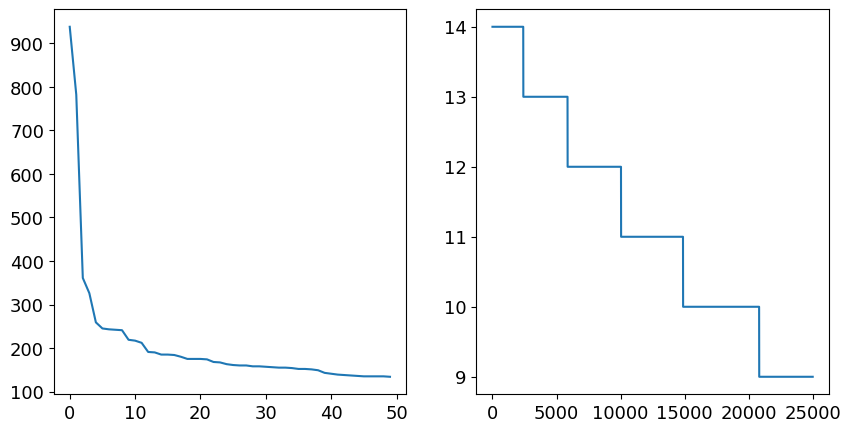

In [37]:
#从上图可看，很少用户点击次数非常多(超过拐点值)。但大多数用户点击次数集中在一个范围,从上图看不出这些用户的差异。所以画更细致的图
#点击次数在前50名的用户：可以看到前50名大概在200次左右(大于100次)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.figure(figsize=(5, 3))
a= plt.plot(user_click_item_count[:50])
#50名是试出来的————可以尝试前30 前100 这样尝试 ； 
#用户总数：25W左右(从图看) 前50个就显得特别少了。少部分人的特征

#点击次数排名在[25000:50000]之间:可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户
plt.subplot(1, 2, 2)
b = plt.plot(user_click_item_count[25000:50000])

点击次数排**前50**的用户的点击次数都在**100次以上**。<br>
思路：<br>
（1）我们可以**定义点击次数大于等于100次**的用户为**活跃用户**。<br>
（2）可以看出**点击次数小于等于15次**的用户非常的多，这些用户可以认为是**非活跃用户**<br>
（3）其余为中等活跃用户<br>
这是一种**简单的处理思路**， 判断用户活跃度。<br>
更加全面的是再结合上点击时间，后面我们会**基于点击次数和点击时间**两个方面来判断用户活跃度<br>

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


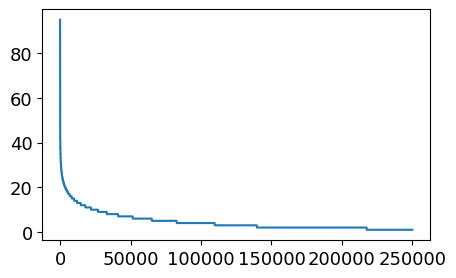

In [38]:
#用户点击的新闻类型的偏好 ~可以用于度量用户的兴趣是否广泛。
plt.figure(figsize=(5, 3))
_ = plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

从上图中可以看出**有一小部分用户**阅读类型是极其**广泛**的，**大部分人**都处在**20个新闻类型以下**。

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


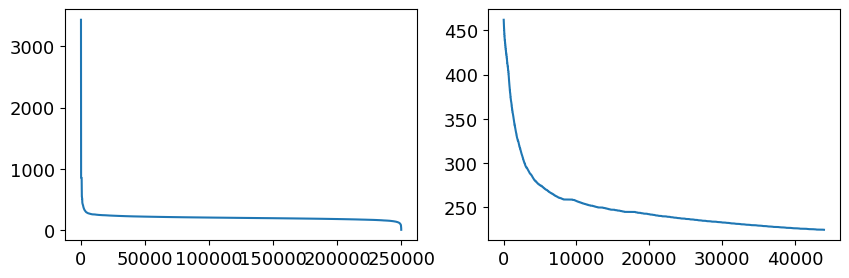

In [39]:
#用户查看文章的长度的分布 ~通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
_ =plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))


#从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。 
#大多数人偏好于阅读字数在200-400字之间的新闻。

#挑出大多数人的区间仔细看看
plt.subplot(1,2,2)
_ = plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

从上图中可以发现有**一小部分人**看的文章**平均词数非常高**，也有**一小部分人**看的平均文章**词数非常低**。 <br>
**大多数人**偏好于阅读字数在**200-400**字之间的新闻。具体的，大多数人都是看**250字以下**的文章<br>
最小平均词数：8； 25~75%：180~220字。<br>
所以**可以考虑用该特征表示用户的阅读长度偏好**。

In [40]:
#用户点击新闻的时间分析————点击时间差~先看看每个用户的时间差差异。
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

def mean_diff_time_func(df, col):
    df = pd.DataFrame(df, columns=[col])
    df['time_shift1'] = df[col].shift(1).fillna(0)
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    return df['diff_time'].mean()


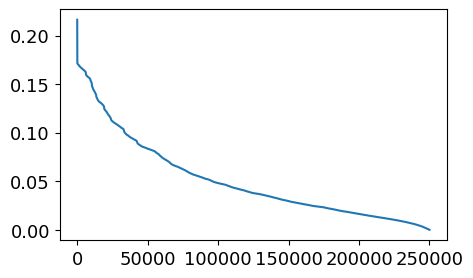

In [41]:
# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id')[['click_timestamp', 'created_at_ts']].apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))

plt.figure(figsize=(5, 3))
_ = plt.plot(sorted(mean_diff_click_time.values, reverse=True))

从上图可以发现**不同用户点击文章的时间差**是**有差异**的。<br>
所以时间戳变量可以使用：<br>
第一种使用在**item**上：序列建模时用于时间编码P_timegap；<br>
第二种使用在**用户**上：刻画用户点击间隔长短<br>

时间差用均值标准化好还是用minmax归一化好呢
这是一个非常好的问题！在推荐系统中，时间差特征的处理对模型效果影响很大。对于**时间差（Time Difference）这种特征，它通常具有长尾分布（Long-tail Distribution）**的特性：绝大多数的点击间隔很短（几秒到几分钟），但会有少量极端的间隔（比如用户隔了一天才再次打开App）。
我们来对比一下两种归一化方式在处理这种数据时的优劣：
1. Min-Max 归一化 (当前代码中使用的方式)公式: $x' = \frac{x - min}{max - min}$
优点: 将数据严格映射到 [0, 1] 区间，对某些对输入范围敏感的模型（如神经网络）比较友好。
缺点（致命）: 对异常值极其敏感。假设大多数时间差是 1~60秒，但有一个异常值是 86400秒（一天）。Min-Max 之后，那个 86400秒会变成 1.0，而正常的 60秒会变成 $60/86400 \approx 0.0007$。结果: 绝大多数有效的数据都被“挤压”到了 0 附近一个极小的区间内，丧失了区分度，神经网络很难学到有效信息。2. 均值标准化 (Z-Score Standardization)公式: $x' = \frac{x - \mu}{\sigma}$ （$\mu$是均值，$\sigma$是标准差）优点: 对异常值不如 Min-Max 那么敏感，保留了数据的分布结构。缺点: 如果数据严重偏态（长尾），均值和标准差本身就会被异常值拉偏，导致大部分正常数据可能集中在 -0.5 左右，而长尾数据在 +10 甚至更高。最佳实践推荐：Log 变换 + 归一化对于时间差这种严重的偏态数据，工业界和竞赛中最常用的标准做法是先进行对数变换（Log Transformation），再进行归一化。Log 变换: $x' = \log(x + 1)$ (加1是为了防止 $log(0)$)作用: Log 函数可以极大地“压缩”长尾部分的值，同时“拉伸”头部较小的值。它能把偏态分布转换成更接近正态的分布。我建议你修改代码，采用 Log + MinMax 或 Log + Z-Score。

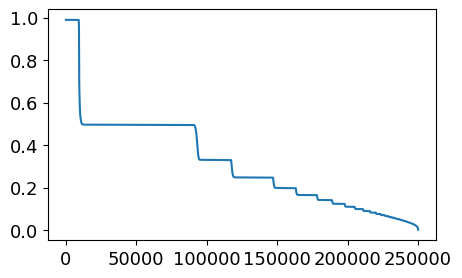

In [42]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')[['click_timestamp', 'created_at_ts']].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))

plt.figure(figsize=(5, 3))
_ = plt.plot(sorted(mean_diff_created_time.values, reverse=True))

从上图可以发现**不同用户点击文章的文章创建时间差是有差异**的！<br>
但怎么用这个特性呢？继续分析————这个**可能是由于用户读了不同类型的文章**导致的，为了验证这个猜想，利用文章的id embedding的相似度来看看是不是文章差异比较大？

In [48]:
# 用户前后点击文章的相似性分布
item_idx_2_rawid_dict = dict(zip(item_emb_df['article_id'], item_emb_df.index))
#del item_emb_df['article_id']
item_emb_np = np.ascontiguousarray(item_emb_df.values, dtype=np.float32)

# 随机选择5个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()



,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
14898,243960,162655,0.001167,4,1,17,1,16,1,11,11,281,0.989199,245
14899,243960,16129,0.001196,4,1,17,1,16,2,10,11,7,0.989184,200
14900,243960,96812,0.001205,4,1,17,1,16,2,9,11,209,0.989201,195
64072,226090,272143,0.005329,4,3,20,1,21,2,1,1,399,0.989235,184
100198,212758,272143,0.008807,4,3,2,1,25,1,1,1,399,0.989235,184


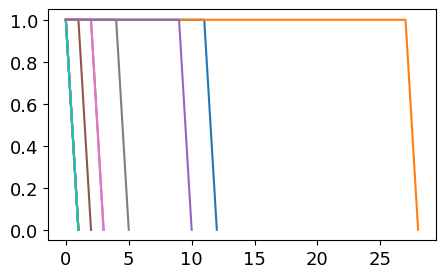

In [49]:
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_emb_np[item_idx_2_rawid_dict[item_list[i]]]
        emb2 = item_emb_np[item_idx_2_rawid_dict[item_list[i+1]]]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

plt.figure(figsize=(5, 3))
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

可以看到，每一条线代表不同用户的点击文字的前后相似度————发现**有些相似度波动比较大，有些波动比较小，也是有一定的区分度的**。这是不是可以说明，**使用序列建模**的方法比较好呢？<br>
所以“前后文章的创建时间差异较大”这个特性不构造专门的特征，而是我们使用序列建模模型的一个动机。

#### **双侧分析——user_to_item**

[15935, 15666, 15383, 15170, 14009, 13998, 13277, 13041, 11968, 11511, 10647, 9942, 9681, 9653, 9615, 9530, 9346, 9158, 8918, 8461, 8155, 7956, 7811, 7796, 7729, 7163, 7138, 7094, 7091, 7004, 6984, 6909, 6802, 6791, 6514, 6355, 6192, 6135, 6115, 6042, 5955, 5946, 5890, 5844, 5817, 5808, 5740, 5725, 5702, 5673, 5659, 5603, 5583, 5549, 5335, 5302, 5162, 5118, 5093, 5032, 5017, 4964, 4957, 4885, 4870, 4852, 4772, 4712, 4653, 4544, 4487, 4399, 4338, 4202, 4092, 4086, 4046, 3838, 3765, 3712, 3697, 3678, 3670, 3640, 3630, 3622, 3601, 3566, 3520, 3507, 3493, 3433, 3383, 3360, 3356, 3353, 3337, 3252, 3249, 3197, 3164, 3146, 3139, 3122, 3122, 3102, 3066, 2958, 2934, 2899, 2844, 2804, 2803, 2764, 2763, 2748, 2707, 2678, 2624, 2598, 2592, 2557, 2554, 2510, 2495, 2492, 2468, 2466, 2460, 2456, 2441, 2440, 2411, 2402, 2383, 2337, 2319, 2305, 2283, 2280, 2255, 2247, 2241, 2237, 2225, 2220, 2193, 2190, 2184, 2140, 2134, 2077, 2063, 2056, 2045, 2033, 2023, 2011, 2001, 1997, 1993, 1970, 1968, 1966, 1957

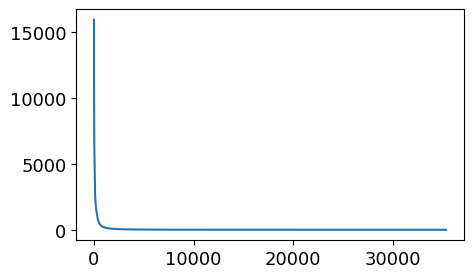

In [50]:
# 新闻点击次数分析：某个item被点击了多少次
#item_click_count=user_click_merge.groupby('click_article_id')['user_id'].count().sort_values(ascending=False)
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)
pd.set_option('display.max_rows', None)
print(item_click_count) #可以复制到excel里看
plt.figure(figsize=(5, 3))
_ = plt.plot(sorted(item_click_count,reverse=True))

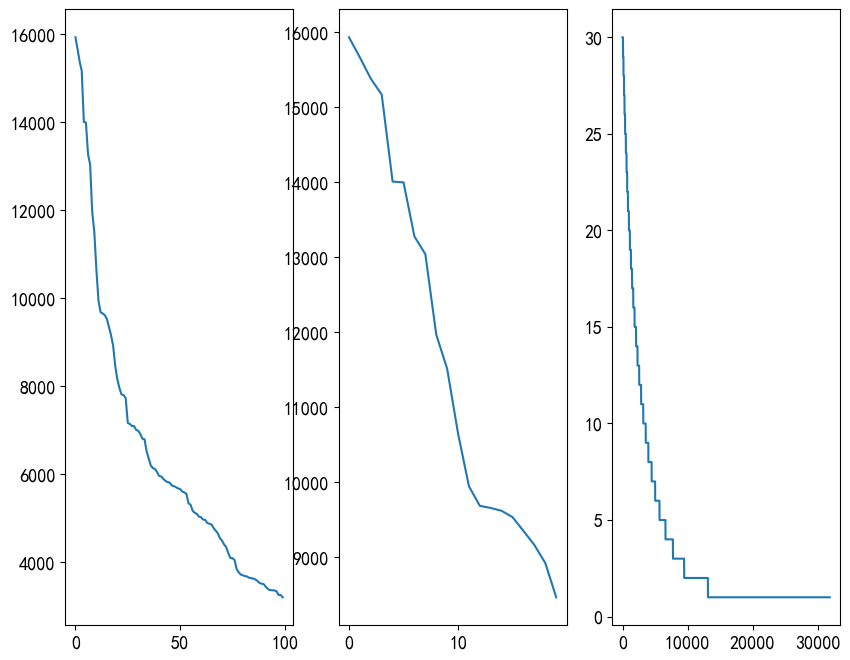

In [99]:
#可以看看点击次数前100个item的分布
plt.figure(figsize=(10, 8))
plt.subplot(1,3,1)
a= plt.plot(item_click_count[:100])

#看看前20
plt.subplot(1,3,2)
b = plt.plot(item_click_count[:20])

#看看第3500个之后
plt.subplot(1,3,3)
_ = plt.plot(item_click_count[3500:])

可以看到：<br>
（1）点击次数最多的**前100**篇新闻，点击次数**大于1000次**<br>
（2）点击次数最多的**前20**篇新闻，点击次数**大于2500**。<br>
（3）很多新闻只被点击过一两次。**第10000个item之后**很快到了**1~5次**的程度<br>
思路：可以**定义这些新闻为热门/冷门新闻**， 这个也是简单的处理方式，后面我们也是根据点击次数和时间进行文章热度的一个划分。<br>

In [103]:
#新闻共现频次：两篇新闻连续出现的次数————看哪两个item之间被同时看过

#sort_values('click_timestamp')~确保时间顺序
#tmp.groupby(['user_id'])['click_article_id']~按user id 拿出点击文章(已先后顺序)| .transform(lambda x:x.shift(-1))~错位一位：得到next_item
#在union_item = tmp.groupby..这一步，通过对click_article_id和next_item进行分组，
#然后聚合计算每种跳转模式（从某个文章跳转到另一个文章）出现的次数（count）。
#这里的结果表示了从一篇文章跳转到另一篇文章的行为发生的频次。最终结果按count降序排列，以便更容易看到最常见的跳转路径。
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()


,count
count,433596.000000
mean,3.184146
std,18.851729
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


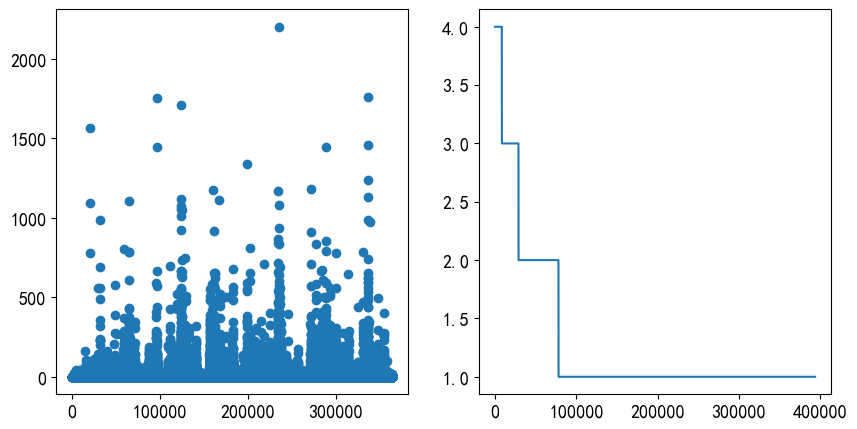

In [ ]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
_ = plt.scatter(x, y)
plt.subplot(1,2,2)
_ = plt.plot(union_item['count'].values[40000:]) 

从右图(从第4万个开始)可以看到，第10W之后的pair只出现一次，换句话说**大概有7万个pair至少共现一次**,第4万个之前共现次数一次以上。
**怎么使用这个特点呢？————序列建模应该能自动补抓到？**


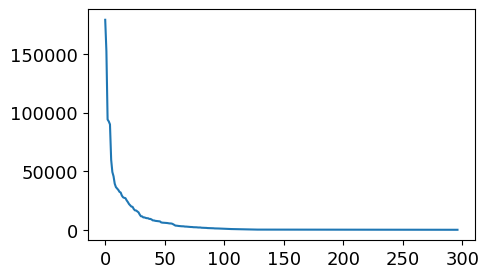

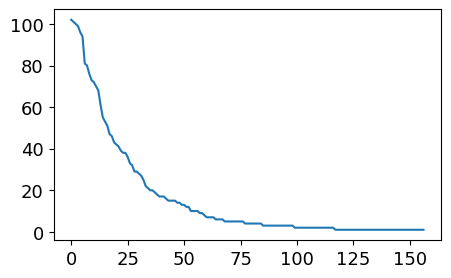

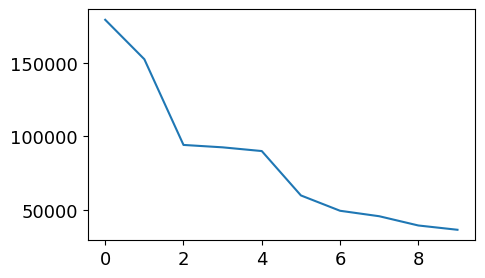

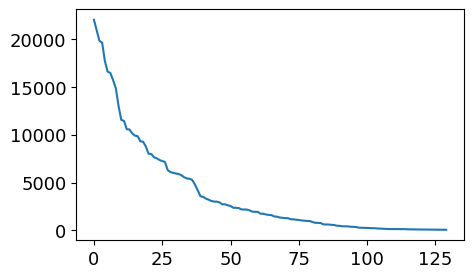

In [66]:
#新闻文章类别信息
#不同类型的新闻出现的次数
plt.figure(figsize=(5, 3))
_ = plt.plot(user_click_merge['category_id'].value_counts().values)

#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.figure(figsize=(5, 3))
_ = plt.plot(user_click_merge['category_id'].value_counts().values[140:])

#直线下降段：
plt.figure(figsize=(5, 3))
_ = plt.plot(user_click_merge['category_id'].value_counts().values[:10])

#拐角下降段：
plt.figure(figsize=(5, 3))
_ = plt.plot(user_click_merge['category_id'].value_counts().values[20:150])

从两个图来看，类别出现的数量可以大致分为**出现非常多(直线骤降段)、出现次数较多(拐角缓慢下降段)和出现次数少(直线段)**<br>
第二个图可以看，第150个往后，次数在100次以下了。<br>
所以可以考虑：文章类别的词表可以在**出现次数少那些类别归为一大类**，其他类别正常embedding化。<br>

#### **基本检查**
item id emb 是囊括了train 和 test里点击的文章不？

In [ ]:
train = set(trn_click["click_article_id"].unique())
test = set(tst_click["click_article_id"].unique())
items = set(item_df["click_article_id"].unique())

print("训练集的item均在item库内？",train in items)
print("测试集的item均在item库内？",test in items)

训练集的item均在item库内？ False
测试集的item均在item库内？ False


In [131]:
# 获取训练集、测试集中出现的文章 ID 集合
train_items = set(trn_click["click_article_id"].unique())
test_items = set(tst_click["click_article_id"].unique())
item_pool = set(item_df["click_article_id"].unique())  # 物品库

# 判断是否所有训练/测试集中的 item 都在物品库中
print("训练集的所有文章均在物品库内？", train_items.issubset(item_pool))
print("测试集的所有文章均在物品库内？", test_items.issubset(item_pool))

训练集的所有文章均在物品库内？ True
测试集的所有文章均在物品库内？ True


# **总结**<br>
**用户侧**：<br>
（1）从**点击时间clik_timestamp**来看，分布较为平均，可不做特殊处理。由于时间戳是13位的，后续将时间格式转换成10位方便计算。<br>
（2）从**点击环境click_environment**来看，仅有1922次（占0.1%）点击环境为1；仅有24617次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4，所以这个特征可能是无用的<br>
（3）从**点击设备组click_deviceGroup**来看，设备1占大部分（60.4%），设备3占36%<br>
（4）从**点击城市click_country**来看，基本上只在某一个城市，所以这个特征可能是无用的<br>
（5）从**点击系统click_os**来看,主要集中在三大类系统2、17、20中，其中17最多；可以考虑2/17/20/其余 分为4大类<br>

**测试集的分布和训练集分布类似**<br>

**item侧**：<br>
（1）词数分布(前99%)下服从正态分布，有特别长的词数。所以**可以考虑将文章按词数特征分为类似长/中/短 的几类**<br>
（2）文章的类别分布较正常————但最终还是看用户看哪些类别多(user_to_item)<br>


**item_to_user**<br>
（1）**有1605541（约占99.2%）的用户未重复阅读过文章**，仅有极少数用户重复点击过某篇文章。 可以考虑这个单独制作成用户特征<br>
（2）绝大多数数的用户的**点击环境是比较固定的**。思路：可以基于**这些环境的统计特征**来**代表该用户本身的属性**。**最有可能变化**的是**点击的文章来源**发生变化<br>
（3）从上图中可以看出**有一小部分用户**阅读类型是极其**广泛**的，**大部分人**都处在**20个新闻类型以下**。————**用户兴趣宽度**<br>
（4）可以根据**点击次数**来判断活跃与否————简单但不妥：可能只是刚用没多久呢？————后续继续优化：结合时间的活跃度量<br>
（5）**大多数人**偏好于阅读字数在**200-400**字之间的新闻。具体的，大多数人都是看**250字以下**的文章。最小平均词数：8； 25~75%：180~220字。所以**可以考虑用该特征表示用户的阅读长度偏好**。<br>
（6）**不同用户点击文章的时间差**是**有差异**的。所以时间戳变量可以使用：<br>
       第一种使用在**item**上：序列建模时用于时间编码P_timegap；<br>
       第二种使用在**用户**上：刻画用户点击间隔长短<br>
（7）“前后文章的创建时间差异较大”可能由**用户前后阅读文章相似度不同**导致的，因此我们使用序列建模模型。除以之外，还可以考虑**用户对于文章时效的偏好**<br>


**user_to_item**<br>
（1）可以**定义这些新闻为热门/冷门新闻**， 简单的处理方式:根据点击次数，后面我们也是根据点击次数和时间进行文章热度的一个划分<br>
（2）**大概有7万个pair至少共现一次**,第4万个之前共现次数一次以上。即前后阅读不同的文章可能存在一定的关联规则！**怎么使用这个特点呢？————序列建模应该能自动补抓到？**<br>
（3）类别出现的数量可以大致分为**出现非常多(直线骤降段)、出现次数较多(拐角缓慢下降段)和出现次数少(直线段)**，可以考虑：文章类别的词表可以在**出现次数少那些类别归为一大类**，其他类别正常embedding化<br>


**排序阶段**：对于每个用户召回的每个商品， 做特征。 具体步骤如下： <br>
对于每个用户， 获取最后点击的N个商品的item_id， * 对于该用户的每个召回商品：计算与上面最后N次点击商品<br>
    **通用**：相似度的(和、最大， 最小、均值等)**【这一块类似于DIN模型的兴趣提取】**、该用户的相似性特征<br>
    **该数据集可用**：**创建时间差**特征，相似性特征，**平均字数差**特征，<br>


已有的特征和可构造特征： <br>
1. 文章自身的特征：文章字数，文章创建时间， 文章的embedding （articles表中) ✔<br>
2. 用户点击环境特征， 那些设备的特征(这个在df中) ✔<br>
3. 对于用户和商品还可以构造的特征： <br>
（1）基于用户的点击文章次数和点击时间构造可以表现用户活跃度的特征 <br>
（2）基于文章被点击次数和时间构造可以反映文章热度的特征 <br>
（3）用户的时间统计特征： 根据其点击的历史文章列表的点击时间和文章的创建时间做统计特征，比如求均值， 这个可以反映**用户对于文章时效的偏好**✔<br>
（4）用户的主题爱好特征， 对于用户点击的历史文章主题进行一个统计， 然后对于当前文章看看是否属于用户已经点击过的主题（排序阶段专用）<br>
（5）用户的字数爱好特征， 对于用户点击的历史文章的字数统计， 求一个均值 ✔<br>

**注意：排序阶段和召回阶段做特征稍有不同**；<br>
**排序阶段**:<br>
(1)可以和当前召回item做更多特征：**当前召回item与历史item的各个属性的差异** ~ 序列建模可以代替<br>
(2)当前召回item也可以和用户做特征：**用户各种item偏好属性 vs 当前召回item的属性**,比如用户偏好适中长度文本 vs 当前召回是短长度|主题偏好等等,具体看有什么属性<br>

**用户活跃度**衡量优化：<br>
如果某个用户点击文章之间的时间间隔比较小， 同时点击的文章次数很多的话， 那么我们认为这种用户一般就是活跃用户。<br>
当然衡量用户活跃度的方式可能多种多样，其中一种：<br>
（1）1. 首先根据用户user_id分组， 对于每个用户，计算**点击文章的次数**， **前后两两点击文章时间间隔**的均值 2. 把**点击次数取倒数**和**时间间隔的均值**各自归一化(相加需要量纲相同)，然后**两者相加合并**，该值越小，说明用户越活跃 <br>
让**模型自己学会**越大越活跃还是越小越活越

**item热度**衡量优化：<br>
和上面同样的思路， **如果一篇文章在很短的时间间隔之内被点击了很多次**， 说明文章比较热门，实现的逻辑和上面的基本一致， 只不过这里是按照点击的文章进行分组： 1. 根据文章进行分组， 对于每篇文章的点击按照时间先后排序， 计算点击的时间间隔(越长越不热) 2. 将用户的数量取倒数， 然后用户的数量倒数和时间间隔各自归一化， 然后相加得到热度特征， 该值越小， 说明被点击的次数越大且时间间隔越短， 文章比较热
让**模型自己学会**越大越热还是越小越热

### 训练集与测试集过渡<br>
若 训练的时候使用了标准化、归一化等，比如对时间戳标准化，到测试集时应该应用和训练集同参数的标准化or归一化，即训练集的均值、方差记录下来用于测试集的标准化。